In [33]:
import torch
import torch.nn as nn
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
!pip install torchsummary 
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [18]:
data_destination = '/kaggle/working/'
fmnist_data =  datasets.FashionMNIST(data_destination, download=True, train=True)
data_destination_test = '/kaggle/working/test'
fmnist_val =  datasets.FashionMNIST(data_destination_test, download=True, train=False)

In [19]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/255 # scalling
        x = x.view(-1, 1, 28, 28) # reshaping images (batch_size, channels, height, width)
        self.x, self.y = x, y
    def __getitem__(self, ix):
        return self.x[ix], self.y[ix]
    def __len__(self):
        return len(self.x)

In [20]:
def get_model():
    model = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3),
        nn.MaxPool2d(kernel_size=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
        nn.MaxPool2d(kernel_size=2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(in_features=3200, out_features=256),
        nn.ReLU(),
        nn.Linear(in_features=256, out_features=10)
    ).to(device)
    loss_func = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=0.001)
    return model, loss_func, optimizer

In [21]:
def train_batch(x, y, model, optimizer, loss_func):
    model.train()
    x, y = x.to(device), y.to(device)
    pred = model(x)
    batch_loss = loss_func(pred, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

In [22]:
@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    max_values, argmaxes = prediction.max(-1) # max class, and class indices
    is_correct = argmaxes == y # does predicted class match the actual y
    return is_correct.cpu().numpy().tolist()

In [23]:
def get_data():
    train = FMNISTDataset(fmnist_data.data, fmnist_data.targets)
    train_dl = DataLoader(train, batch_size=30, shuffle=True)
    val = FMNISTDataset(fmnist_val.data, fmnist_val.targets)
    val_dl = DataLoader(train, batch_size=len(fmnist_val.data), shuffle=True)
    return train_dl, val_dl

In [24]:
@torch.no_grad()
def val_loss(x, y, model):
    model.eval()
    prediction = model(x)
    v_loss = loss_func(prediction, y)
    return v_loss

In [25]:
train_dl , val_dl = get_data()
model, loss_func, optimizer = get_model()
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 26, 26]             640
         MaxPool2d-2           [-1, 64, 13, 13]               0
              ReLU-3           [-1, 64, 13, 13]               0
            Conv2d-4          [-1, 128, 11, 11]          73,856
         MaxPool2d-5            [-1, 128, 5, 5]               0
              ReLU-6            [-1, 128, 5, 5]               0
           Flatten-7                 [-1, 3200]               0
            Linear-8                  [-1, 256]         819,456
              ReLU-9                  [-1, 256]               0
           Linear-10                   [-1, 10]           2,570
Total params: 896,522
Trainable params: 896,522
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.69
Params size (MB): 3.42
Estimated T

In [26]:
train_losses , train_accuracies = [], []
val_losses , val_accuracies = [], []

In [27]:
for epoch in range(10):
    print('epoch: ', epoch)
    
    # training loop
    train_epoch_losses, train_epoch_accuracies = [], []
    for x, y in train_dl:
        x, y = x.to(device), y.to(device)
        train_epoch_losses.append(train_batch(x, y, model, optimizer, loss_func))
        train_epoch_accuracies.append(accuracy(x, y, model))
    train_losses.append(np.mean(train_epoch_losses))
    train_accuracies.append(np.mean(train_epoch_accuracies))
    
    # validation loop
    val_epoch_losses, val_epoch_accuracies = [], []
    for x, y in val_dl:
        x, y = x.to(device), y.to(device)
        val_epoch_losses.append(val_loss(x, y, model).detach().cpu().item())
        val_epoch_accuracies.extend(accuracy(x, y, model))
    val_losses.append(np.mean(val_epoch_losses))
    val_accuracies.append(np.mean(val_epoch_accuracies))

epoch:  0
epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoch:  6
epoch:  7
epoch:  8
epoch:  9


In [28]:
print('train losses: ', train_losses)
print('train accuracies: ', train_accuracies)
print('val losses: ', val_losses)
print('val accuracies: ', val_accuracies)

train losses:  [0.4284329924546182, 0.2776038348712027, 0.2321469598049298, 0.19585952098993584, 0.16504814766021444, 0.14075107639003545, 0.11611695263721049, 0.09998784618341597, 0.0828297401634918, 0.07109945013474499]
train accuracies:  [0.8551833333333333, 0.9061333333333333, 0.9242833333333333, 0.9382333333333334, 0.9500333333333333, 0.9587833333333333, 0.9679333333333333, 0.9740333333333333, 0.97985, 0.9845]
val losses:  [0.2827215790748596, 0.24362707138061523, 0.19246641794840494, 0.16265561431646347, 0.1268976479768753, 0.14113766700029373, 0.09657912328839302, 0.10191832234462102, 0.07630756497383118, 0.06378001968065898]
val accuracies:  [0.8951333333333333, 0.90895, 0.9273, 0.9380833333333334, 0.9521666666666667, 0.9469666666666666, 0.9633333333333334, 0.9623333333333334, 0.9700333333333333, 0.9769]


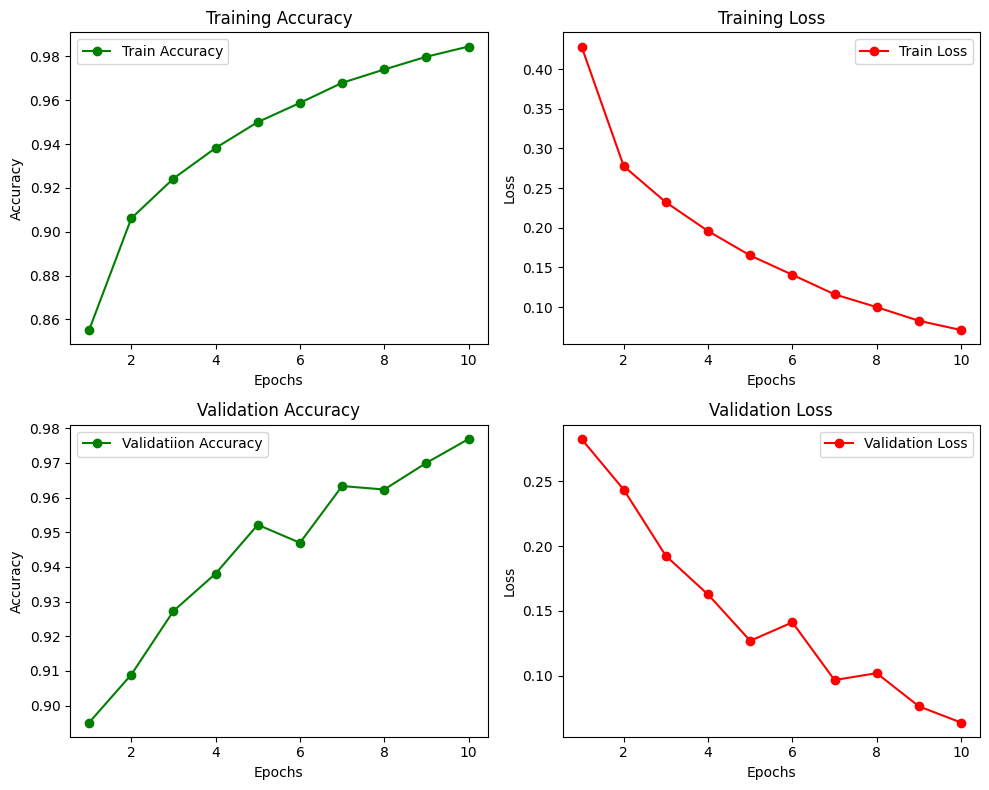

In [29]:
epochs_train = np.arange(1, len(train_losses) + 1)
epochs_val   = np.arange(1, len(val_losses) + 1)
epochs_train_acc = np.arange(1, len(train_accuracies) + 1)
epochs_val_acc   = np.arange(1, len(val_accuracies) + 1)

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# train accuracy
axes[0, 0].plot(epochs_train_acc, train_accuracies, marker='o', color='green', label="Train Accuracy")
axes[0, 0].set_title("Training Accuracy")
axes[0, 0].set_xlabel("Epochs")
axes[0, 0].set_ylabel("Accuracy")
axes[0, 0].legend()
# training loss
axes[0, 1].plot(epochs_train, train_losses, marker='o', color='red', label="Train Loss")
axes[0, 1].set_title("Training Loss")
axes[0, 1].set_xlabel("Epochs")
axes[0, 1].set_ylabel("Loss")
axes[0, 1].legend()

# val accuracy
axes[1, 0].plot(epochs_val_acc, val_accuracies, marker='o', color='green', label="Validatiion Accuracy")
axes[1, 0].set_title("Validation Accuracy")
axes[1, 0].set_xlabel("Epochs")
axes[1, 0].set_ylabel("Accuracy")
axes[1, 0].legend()
# val loss
axes[1, 1].plot(epochs_val, val_losses, marker='o', color='red', label="Validation Loss")
axes[1, 1].set_title("Validation Loss")
axes[1, 1].set_xlabel("Epochs")
axes[1, 1].set_ylabel("Loss")
axes[1, 1].legend()

plt.tight_layout() # adjust spaces
plt.show()

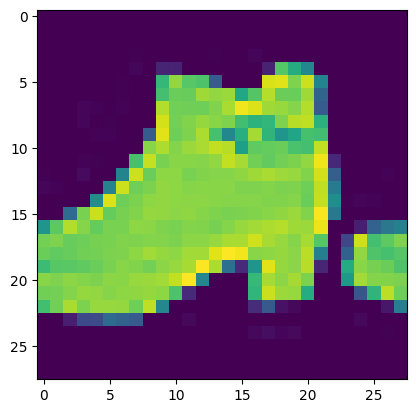

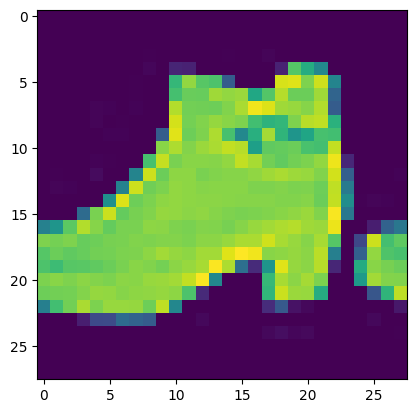

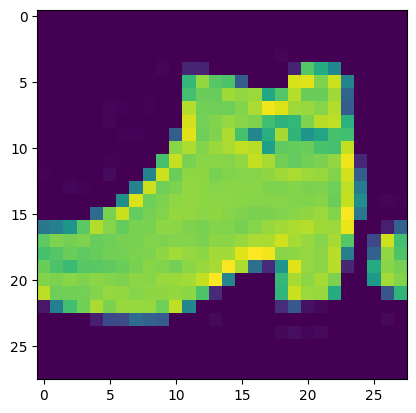

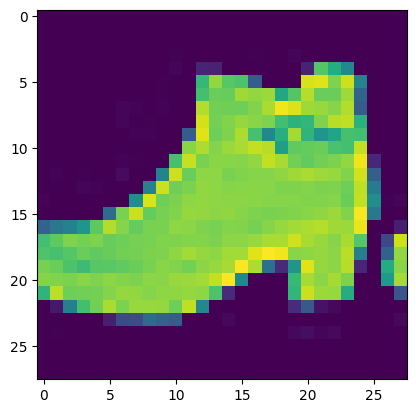

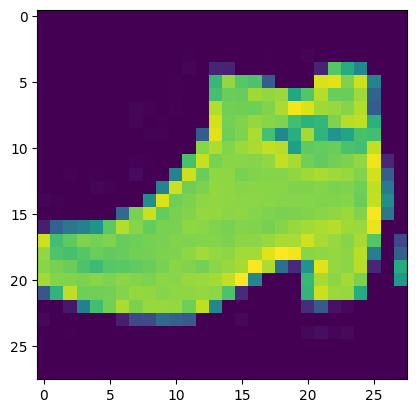

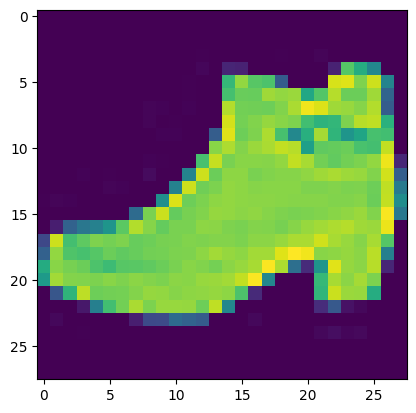

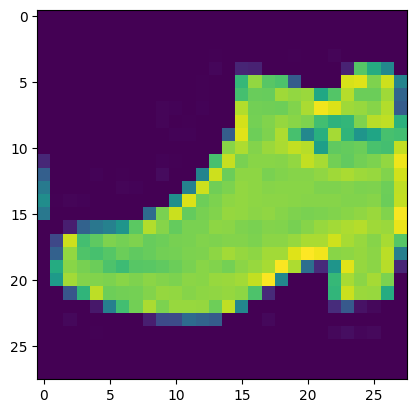

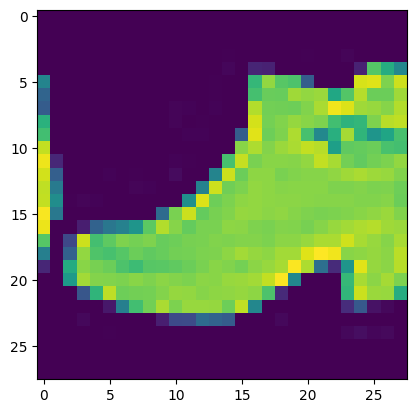

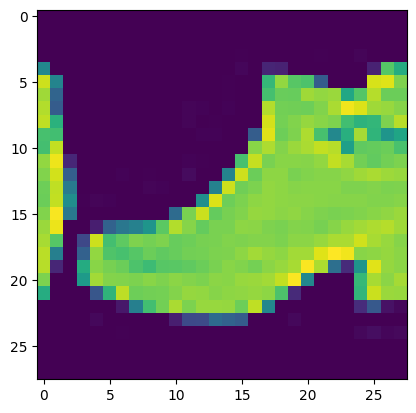

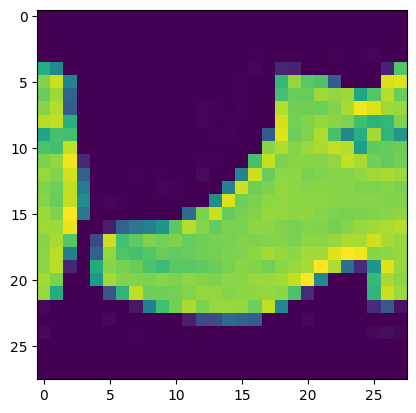

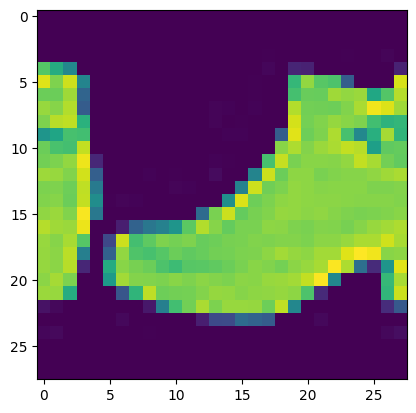

In [38]:
preds = []
ix = 24301
for i in range (-5, 6):
    image = fmnist_data.data[ix] / 255
    image = image.view(28, 28)
    image2 = np.roll(image, i , axis=1)
    plt.imshow(image2)
    plt.show()
    image3 = torch.Tensor(image2).view(-1, 1, 28, 28).to(device)
    np_output = model(image3).cpu().detach().numpy()
    preds.append(np.exp(np_output)/np.sum(np.exp(np_output)))

<Axes: title={'center': 'Probability of each class for various translations'}>

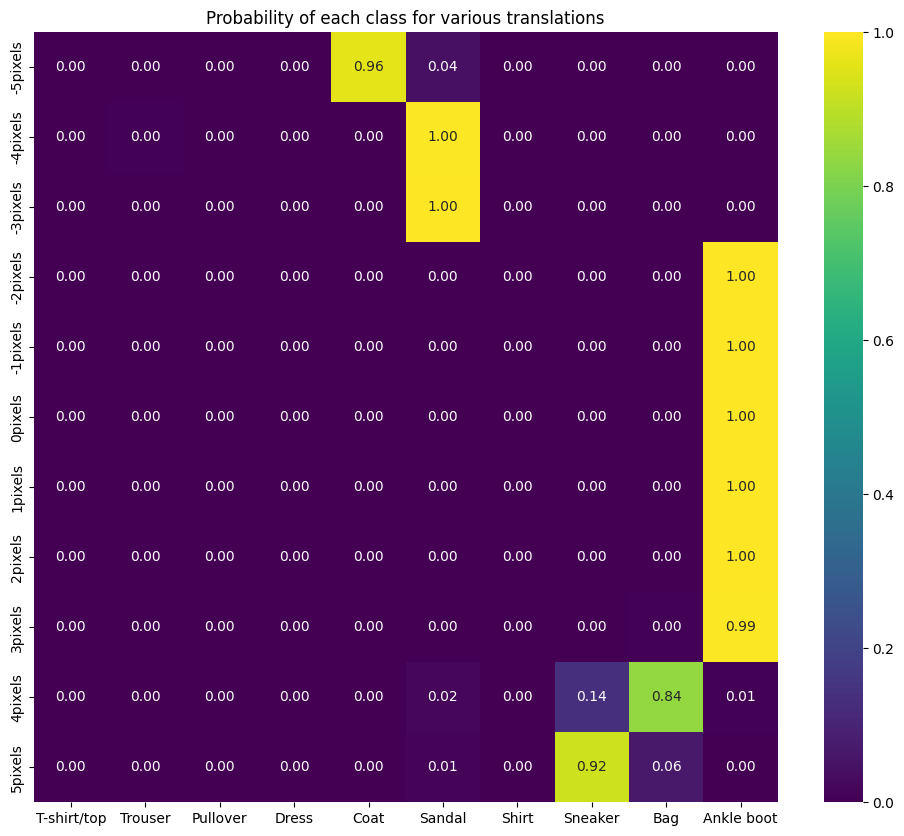

In [39]:
fig, axes = plt.subplots(1,1, figsize=(12, 10))
plt.title('Probability of each class for various translations of image')
sns.heatmap(np.array(preds).reshape(11, 10), annot=True, ax=axes, 
            fmt='.2f',xticklabels=fmnist_data.classes, 
            yticklabels=[str(i) + str('pixels') for i in range(-5, 6)], cmap='viridis')